In [54]:
#Keys: <KeysViewHDF5 ['Day_1', 'Meta']>

In [55]:
import h5py
import pandas as pd

base_path = 'D:/Data/Gait-EMG/Mypredict/'
f = h5py.File(base_path+"MP101.hdf5", "r")

print("Keys in file:", list(f.keys()))

meta_group = f["Meta"]
print("Keys inside Meta:", list(meta_group.keys()))
if "subject" in meta_group.keys():
    data = meta_group["subject"][:]  # this works only if it's a dataset
    print(data.shape, data.dtype)

Keys in file: ['Day_1', 'Meta']
Keys inside Meta: ['Age', 'Code', 'Height', 'No. Days', 'Sex', 'Weight']


In [56]:
print("Keys in file:", list(f.keys()))

meta_group = f["Day_1"]
print("Keys inside Meta:", list(meta_group.keys()))

Keys in file: ['Day_1', 'Meta']
Keys inside Meta: ['MVC', 'Trial_01', 'Trial_02', 'Trial_03', 'Trial_04', 'Trial_05', 'Trial_06', 'Trial_07', 'Trial_08', 'Trial_09', 'Trial_10', 'Trial_11', 'Trial_12', 'Trial_13', 'Trial_14', 'Trial_15', 'Trial_16', 'Trial_17', 'Trial_18', 'Trial_19', 'Trial_20', 'Trial_21', 'Trial_22', 'Trial_23', 'Trial_24', 'Trial_25', 'Trial_26', 'Trial_27', 'Trial_28', 'Trial_29', 'Trial_30', 'Trial_31', 'Trial_32', 'Trial_33', 'Trial_34', 'Trial_35', 'Trial_36']


In [57]:
trial_01 = f["Day_1"]["Trial_01"]

print("Keys in Trial_01:", list(trial_01.keys())) # Trial_01 안에 뭐가 들어있는지 확인
data = trial_01["Acc_Left_Foot"][:]   # numpy array 로 변환
print(data.shape)

Keys in Trial_01: ['Acc_Left_Foot', 'Acc_Left_Shank', 'Acc_Left_Thigh', 'Acc_Pelvis', 'Acc_Right_Foot', 'Acc_Right_Shank', 'Acc_Right_Thigh', 'Acc_T8', 'Ang_L5S1', 'Ang_Left_Ankle', 'Ang_Left_Hip', 'Ang_Left_Knee', 'Ang_Right_Ankle', 'Ang_Right_Hip', 'Ang_Right_Knee', 'EMG_Left_BF', 'EMG_Left_GM', 'EMG_Left_Gmax', 'EMG_Left_Gmed', 'EMG_Left_RF', 'EMG_Left_ST', 'EMG_Left_TA', 'EMG_Left_VL', 'EMG_Right_BF', 'EMG_Right_GM', 'EMG_Right_Gmax', 'EMG_Right_Gmed', 'EMG_Right_RF', 'EMG_Right_ST', 'EMG_Right_TA', 'EMG_Right_VL', 'Gyr_Left_Foot', 'Gyr_Left_Shank', 'Gyr_Left_Thigh', 'Gyr_Pelvis', 'Gyr_Right_Foot', 'Gyr_Right_Shank', 'Gyr_Right_Thigh', 'Gyr_T8', 'Label', 'Markers', 'Time']
(73400, 3)


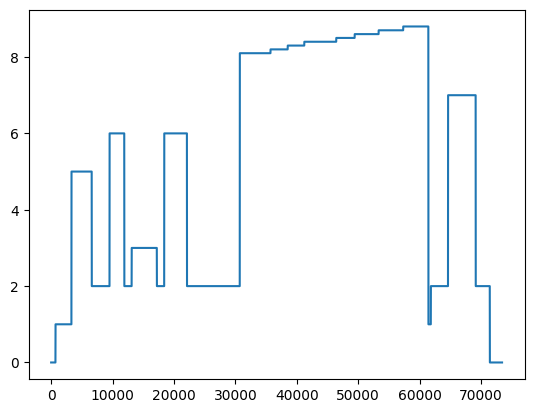

In [58]:
import matplotlib.pyplot as plt
plt.plot(trial_01['Label'][:])

In [59]:
pd.Series(trial_01['Label'][:]).value_counts()

2.0    19000
6.0     6100
8.4     5200
8.1     5000
7.0     4500
3.0     4100
8.8     4100
8.7     4000
8.6     3900
5.0     3300
1.0     3000
8.5     3000
8.2     2800
0.0     2700
8.3     2700
Name: count, dtype: int64

In [2]:
import h5py
import numpy as np
import pandas as pd
from sklearn.utils import resample

def label_extraction(data):
    # --- (1) Label 추출 ---
    y = data["Label"][:].astype(float).ravel()
    valid_idx = np.where((y != -2) & (y != -1))[0] # 불필요한 레이블(-2, -1) 제거
    y = y[valid_idx]
    return y, valid_idx

def stack_signals(trial, keys, valid_idx):
    # --- (2) Modality 별 데이터 추출 ---
    """여러 channel(dataset)을 axis=1 로 합치기"""
    data_list = []
    for k in keys:
        d = trial[k][:]
        if d.ndim == 1:
            d = d[:, np.newaxis]  # (samples,) -> (samples, 1)
        data_list.append(d)
    data = np.hstack(data_list)   # (samples, channels)
    return data[valid_idx]


def Downsample_to_balance_class(y, ):
    # --- (3) Downsampling to balance classes ---
    df = pd.DataFrame({"y": y})

    balanced_idx = []
    for lbl in np.unique(y):
        lbl_idx = np.where(y == lbl)[0]
        min_n = df["y"].value_counts().min()  # 가장 작은 클래스 크기
        sampled_idx = resample(lbl_idx, n_samples=min_n, random_state=42, replace=False)
        balanced_idx.extend(sampled_idx)

    balanced_idx = np.array(balanced_idx)
    return balanced_idx

def random_downsample(X, y=None, fraction=0.5, random_state=42):
    # --- (4) when the data is too much, we randomly remove samples by fraction % ---
    #fraction: 남길 비율

    np.random.seed(random_state)
    n_samples = X.shape[0]
    n_keep = int(n_samples * fraction)
    idx_keep = np.random.choice(n_samples, size=n_keep, replace=False)

    X_down = X[idx_keep]

    if y is not None:
        y_down = y[idx_keep]
        return X_down, y_down
    else:
        return X_down


base_path = 'D:/Data/Gait-EMG/Mypredict/'
f = h5py.File(base_path+"MP101.hdf5", "r")

trial = f["Day_1"]["Trial_01"]

y, valid_idx = label_extraction(trial)
#acc_keys, gyr_keys = [k for k in trial.keys() if k.startswith("Acc_")], [k for k in trial.keys() if k.startswith("Gyr_")]  # 가속도, gyro
#X_acc, X_gyr = stack_signals(acc_keys), stack_signals(gyr_keys)
emg_keys = [k for k in trial.keys() if k.startswith("EMG_")]
X_emg = stack_signals(trial, emg_keys, valid_idx)
print("EMG shape:", X_emg.shape, "y shape:", y.shape)

balanced_idx = Downsample_to_balance_class(y)
# X_acc_bal, X_gyr_bal = X_acc[balanced_idx], X_gyr[balanced_idx]
X_emg_bal = X_emg[balanced_idx]
y_bal = y[balanced_idx]

print("EMG:", X_emg_bal.shape, "y:", y_bal.shape)
X_emg_down, y_down = random_downsample(X_emg_bal, y_bal, fraction=0.5)
print("EMG:", X_emg_down.shape, "y:", y_down.shape)
#pd.Series(y_down).value_counts()

EMG shape: (73400, 16) y shape: (73400,)
EMG: (40500, 16) y: (40500,)
EMG: (20250, 16) y: (20250,)
